# <center>The Simplest Example: Solving 1-dim first-order ODE</center>
<center>DAI, Zhiwen</center>

We just solve the simplest ODE:
\begin{align}
    \frac{df}{dx} &= 1,\\
    f(0) &= 0.
\end{align}

The unique solution is simply $f(x) = x$. 

We use a neural network $\text{net}(x)$ to approximate $f(x)$ and focus on the area $[0, 1]$.

In [1]:
import torch
import numpy as np
from torch.autograd import grad
import matplotlib.pyplot as plt

## Generate data

$m = 10000$.

In [2]:
x = np.random.rand(100,1)
x = torch.tensor(x, requires_grad=True).float()

## Define Network

In [3]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 3),
    torch.nn.ELU(),
    torch.nn.Linear(3, 4),
    torch.nn.ELU(),
    torch.nn.Linear(4, 1),
)

Draw the initial net output.

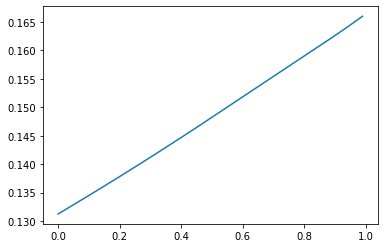

In [4]:
x_test = torch.arange(0, 1, 0.01).float().view(-1, 1)
# print(net(x_test))
plt.plot(x_test.detach().numpy(), net(x_test).detach().numpy())

As we can see, this is far from the function $f(x) = x$.

## Define Loss Function

The implementaion of `loss()` is a little bit tricky. We use `grad` function to obtain gradients and the use the equation that

$$ \nabla_x\sum_{i=1}^{m} \text{net}(x_i) = \left[\frac{d \text{net}(x_i)}{d x_i}\right]_{i=1,...,m},$$

where $x = [x_1,...,x_m]$ to fasten the computation of gradients. We also need to set the flag `create_graph=True` for training.

The loss consists of two parts:

- gradients part: $l_1 = \Vert \frac{d \text{net}(x)}{d x} - 1 \Vert^2$,
- boundary condition: $l_1 = \Vert \text{net}(0) \Vert^2$.

We all use MSE since it is easy to train.

In [5]:
def loss(net, x):
    # first-order condition: 

    # slow way of computing gradient
    l = 0
    # for i in range(len(x)):
    #     x_i = x[i]
    #     l += (grad(net(x_i), x_i, create_graph=True)[0] - 1)**2
    # l /= len(x)
    

    # fast way of computing gradient
    l = torch.sum((grad(torch.sum((net(x))), x, create_graph=True)[0] - 1)**2) / x.shape[0]

    # boundaray condition:
    l += (net(torch.tensor([[0.]]).float())**2).squeeze()
    return l

# test loss
l = loss(net, x)
l

tensor(0.9477, grad_fn=<AddBackward0>)

## Define Optimizer

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

## Training

In [7]:
for step in range(1000):
    l = loss(net, x)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    # print(step, loss(net, x).detach().numpy())

## Draw the Results

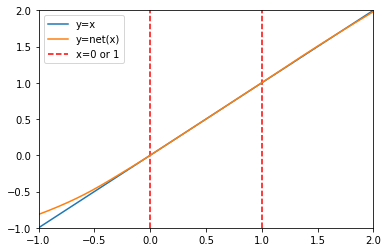

In [8]:
x_test = torch.arange(-1, 2, 0.01).float().view(-1, 1)
# print(x_test)
plt.ylim([-1,2])
plt.xlim([-1,2])
plt.vlines([0,1], -1, 2, colors="r", linestyles="dashed", label="x=0 or 1")
# plt.vlines(1, 0, 2, colors="r", linestyles="dashed", label="x=0")
plt.plot(x_test.detach().numpy(), x_test.detach().numpy(), label="y=x")
plt.plot(x_test.detach().numpy(), net(x_test).detach().numpy(), label="y=net(x)")
plt.legend()

As we can see, the network approximates well in $[0, 1]$, but loses some generality outside the internal.